In [26]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import os
import descartes #if this fails run conda install -c conda-forge descartes from cmd prompt
import geopandas as gpd #if this fails run conda install geopandas from cmd prompt
from shapely.geometry import Point, Polygon
%matplotlib inline

The goal of this notebook is to import US wildfire data from https://www.kaggle.com/rtatman/188-million-us-wildfires and analyze if the wildfires of recent years are normal or abnormal.

Plot the number of wildfires and the total acreage of wildfires over time
Plot for California alone
Plot for entire US

Further Analysis
Plot wildfires on US map

In [2]:
# Import database and load into appropriate dataframes
wf_data = sqlite3.connect("FPA_FOD_20170508.sqlite")
df = pd.read_sql_query("select OBJECTID,FOD_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY from Fires", 
                       wf_data) #remove limit for final evaluation

In [3]:
# create separate dataframe for only california
ca_df=df[df['STATE']=='CA']

Two DataFrames created

    df: data from all US fires
    ca_df: data from all California fires
    
Next Step: Get Fire size and count of fires into a new data frame grouped by year
    

In [4]:
year_df = df.groupby('FIRE_YEAR')['FIRE_SIZE'].agg(['sum','count'])
year_ca_df = ca_df.groupby('FIRE_YEAR')['FIRE_SIZE'].agg(['sum','count'])


In [5]:
year_df.rename(columns={"sum": "FIRE_ACRES", "count": "FIRE_COUNT"}, inplace=True)
year_ca_df.rename(columns={"sum": "FIRE_ACRES", "count": "FIRE_COUNT"}, inplace=True)

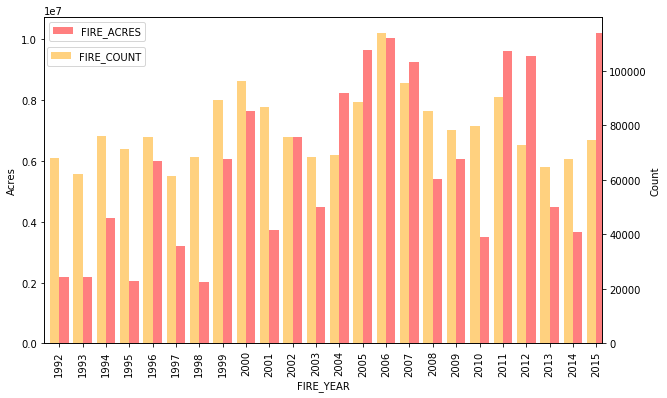

In [6]:
fig = plt.figure(figsize=(10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

year_df.FIRE_ACRES.plot(kind='bar', color='red', ax=ax,position=0, alpha=0.5, width = 0.4)
year_df.FIRE_COUNT.plot(kind='bar', color='orange', ax=ax2, position=1, alpha=0.5, width = 0.4)

ax.set_ylabel('Acres')
ax.legend(loc=0)
ax2.set_ylabel('Count')
ax2.legend(loc=(0.005,0.85))

plt.show()

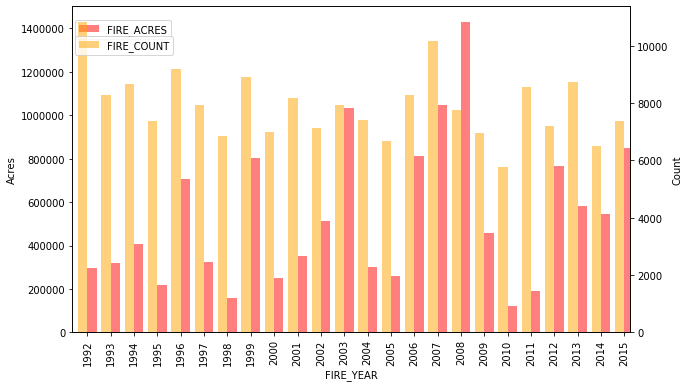

In [7]:
fig_ca = plt.figure(figsize=(10,6)) # Create matplotlib figure

ax = fig_ca.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

year_ca_df.FIRE_ACRES.plot(kind='bar', color='red', ax=ax,position=0, alpha=0.5, width = 0.4)
year_ca_df.FIRE_COUNT.plot(kind='bar', color='orange', ax=ax2, position=1, alpha=0.5, width = 0.4)

ax.set_ylabel('Acres')
ax.legend(loc=(0.005,0.9))
ax2.set_ylabel('Count')
ax2.legend(loc=(0.005,0.85))

plt.show()

Initial Conclusion

The count of fires appears to be flat over time, however the acreage burned is increasing

In California, the same conclusion about count of fires appears true however the acreage burns appears to be cyclical and increasing significantly.

Interesting next steps would be to correlate the spikes in acreage with specific events (weather, etc.)

Next section will be to geographically map the points on a map

In [8]:
us_map = gpd.read_file('states.shp')

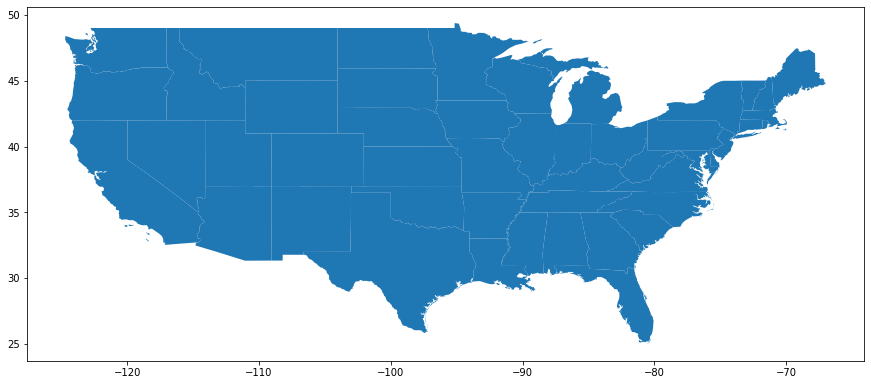

In [9]:
us_map[(us_map.DRAWSEQ > 1) & (us_map.DRAWSEQ < 51)].plot(figsize=(15,15))

In [14]:
# create separate dataframe for only large fires
large_df=df[df['FIRE_SIZE'] > 1000.0]
geometry = [Point(xy) for xy in zip(large_df['LONGITUDE'], large_df['LATITUDE'])]
gdf = gpd.GeoDataFrame(large_df, geometry=geometry)

In [19]:
years = np.arange(1992,2016)
years

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015])

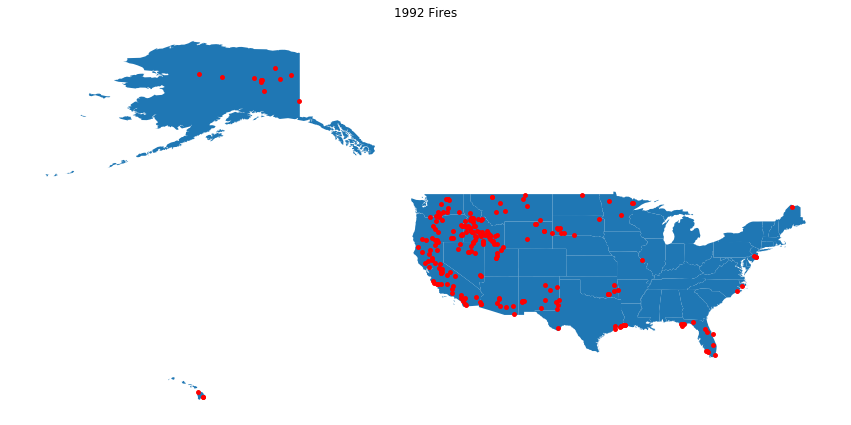

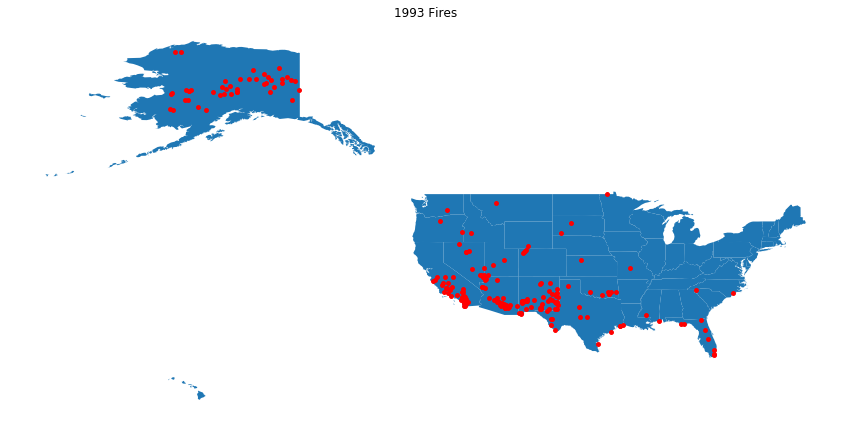

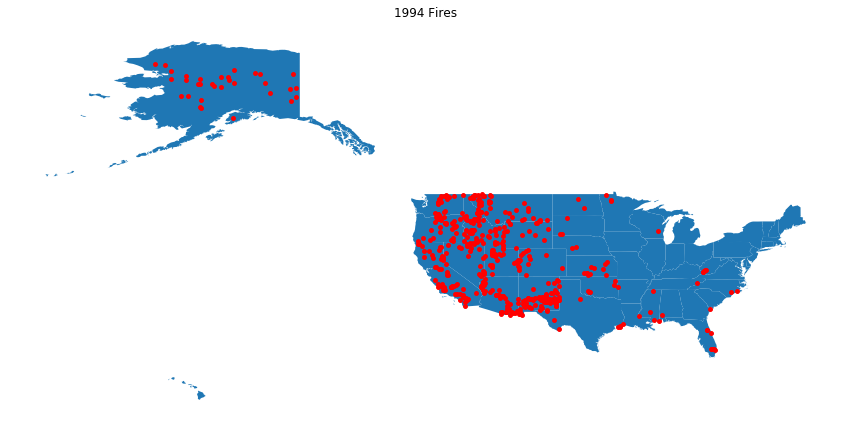

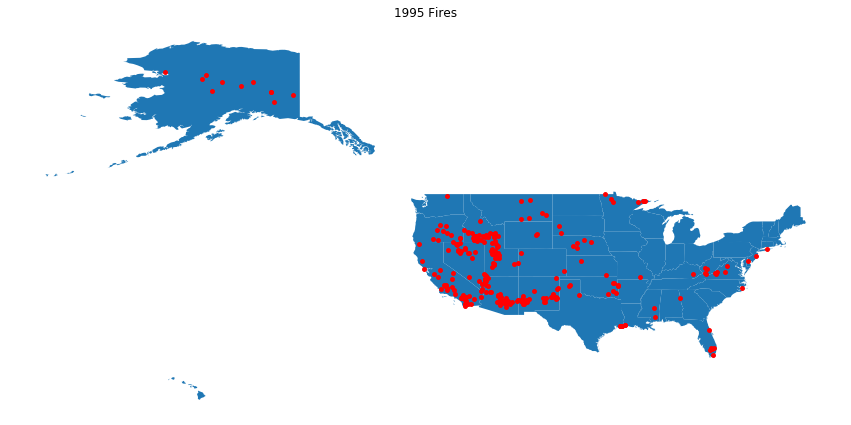

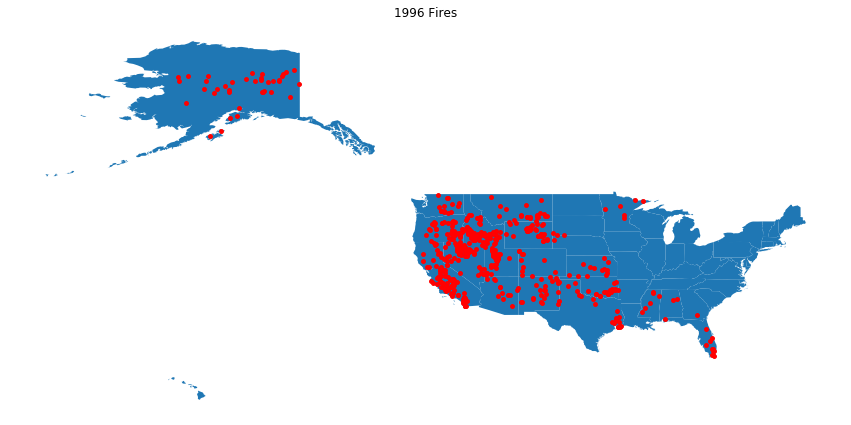

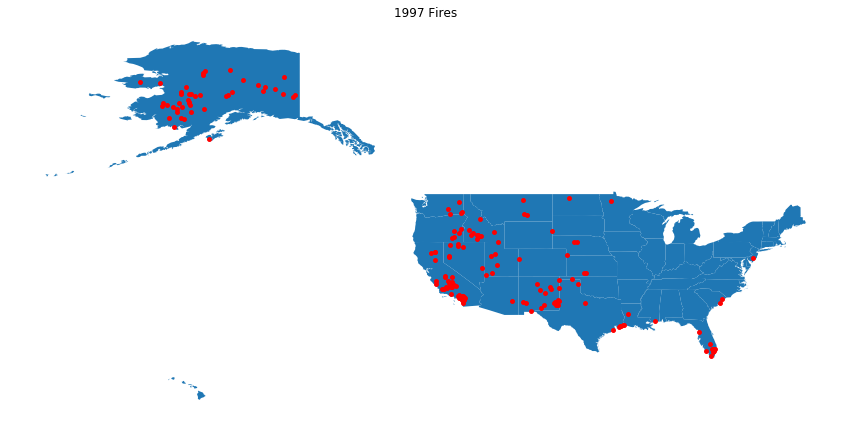

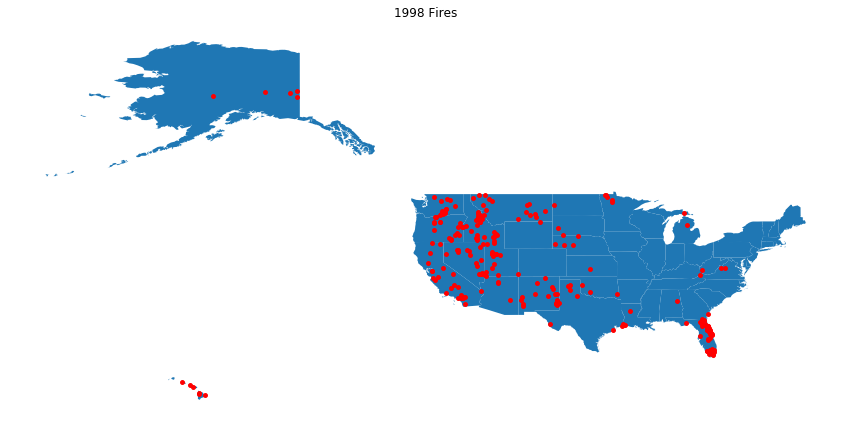

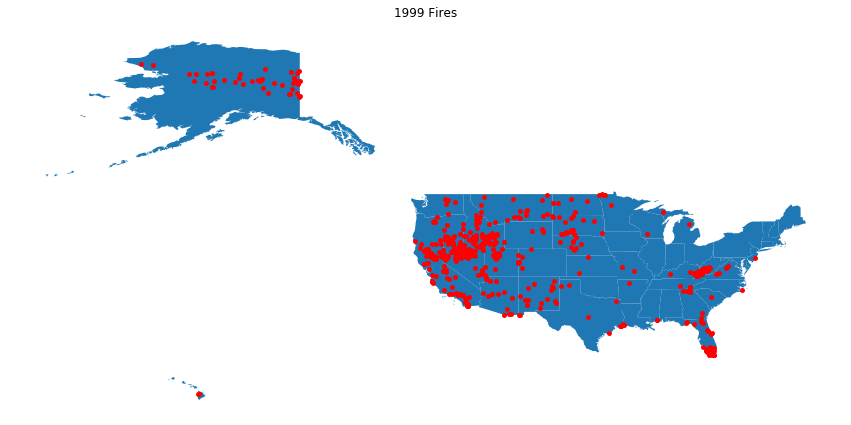

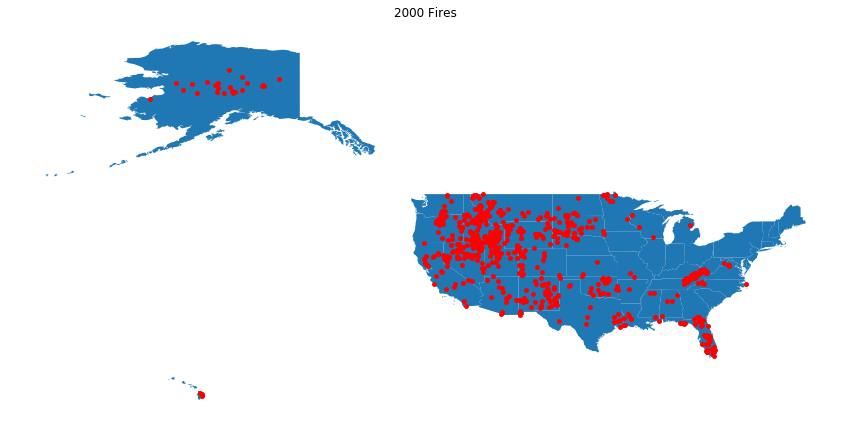

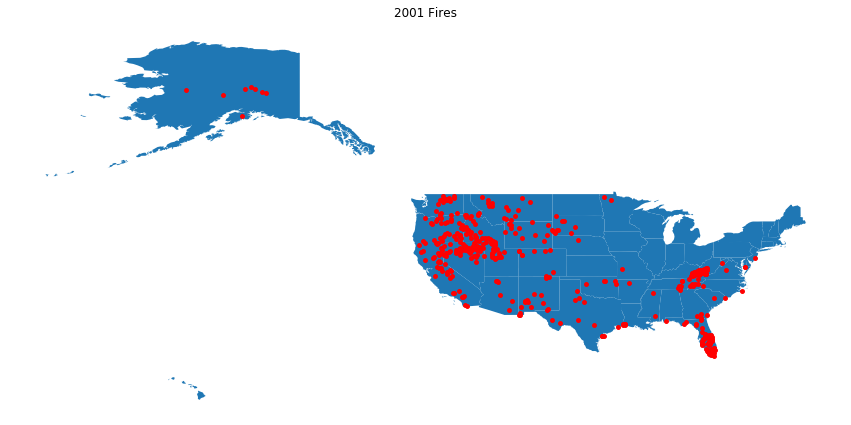

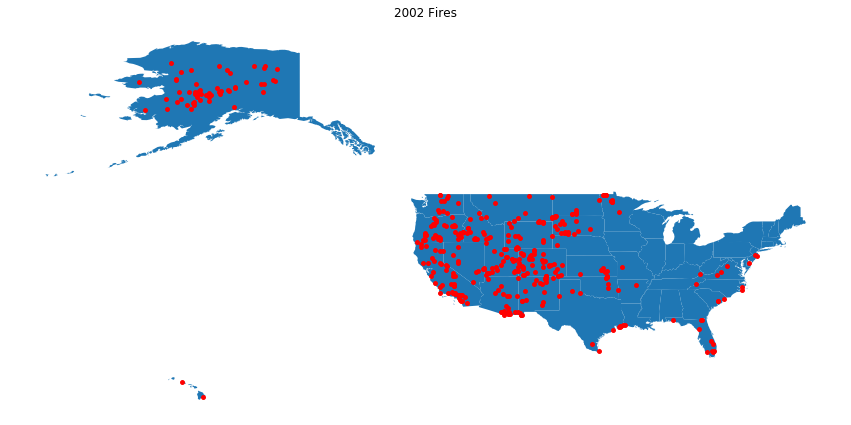

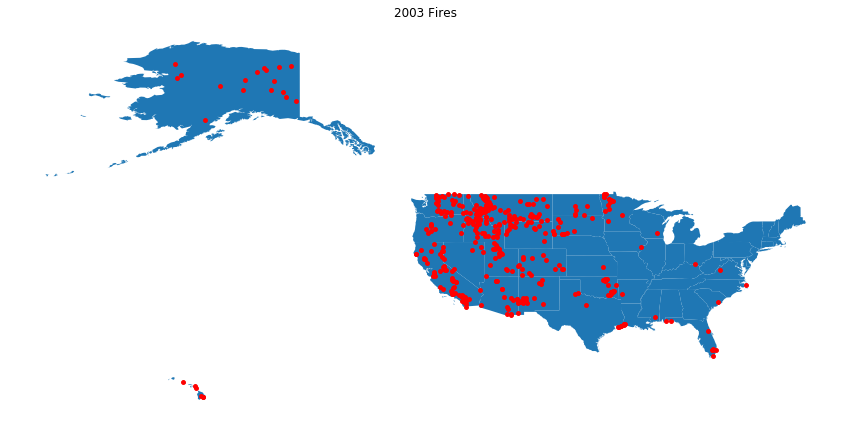

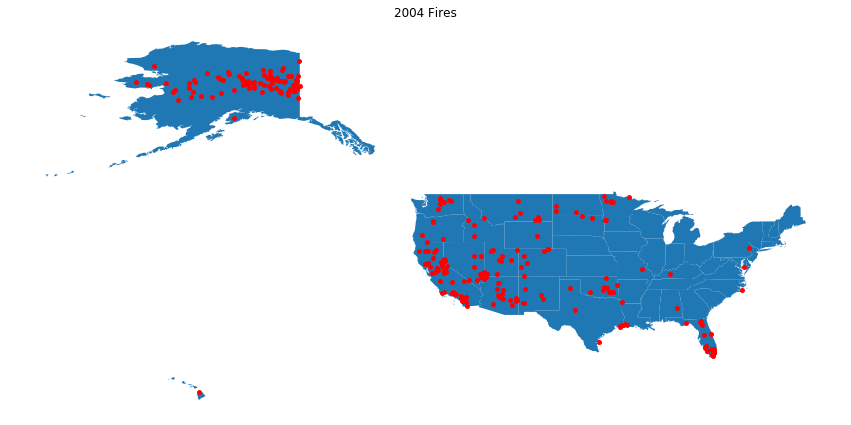

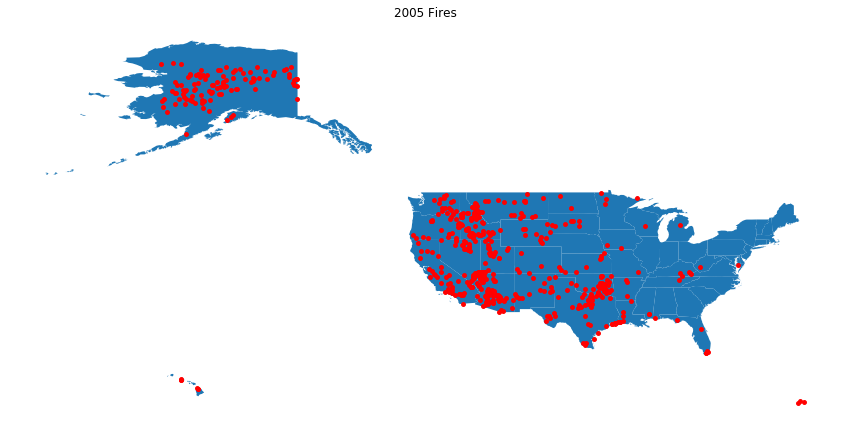

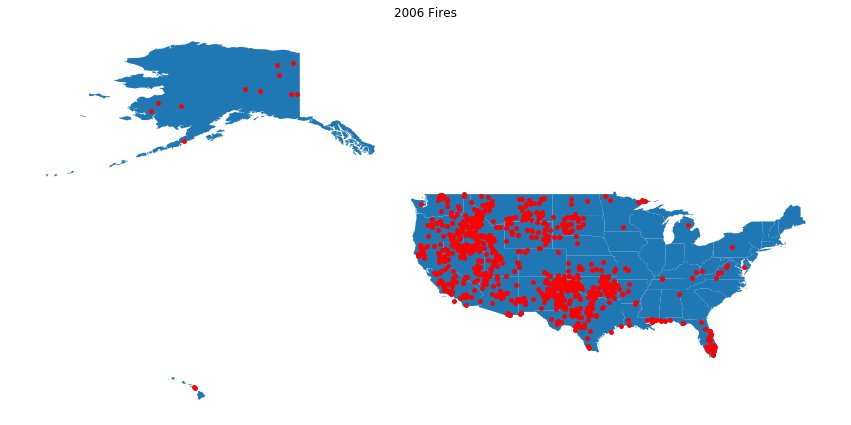

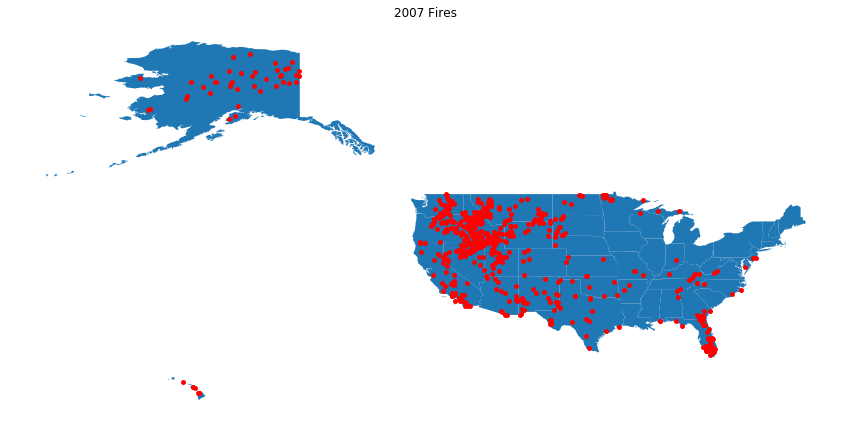

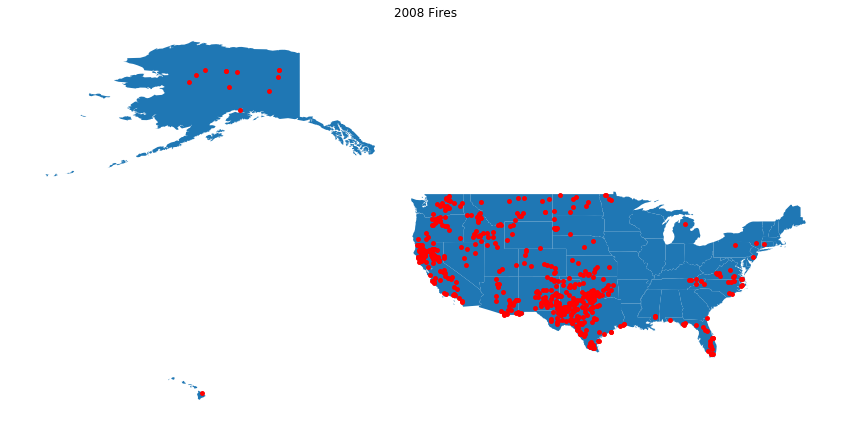

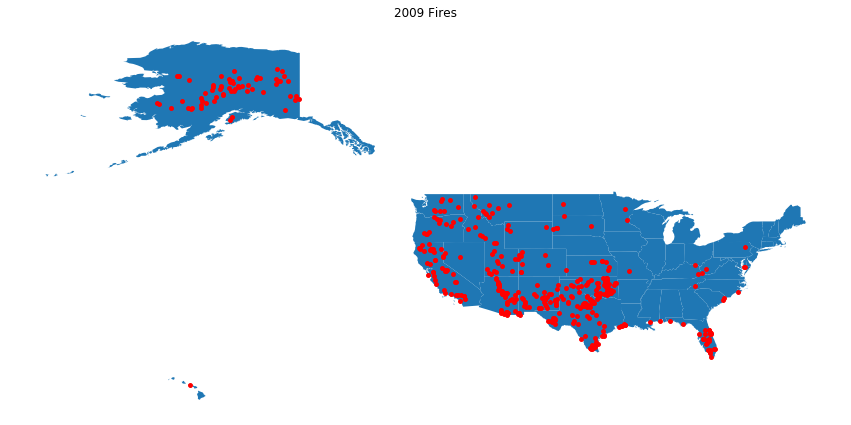

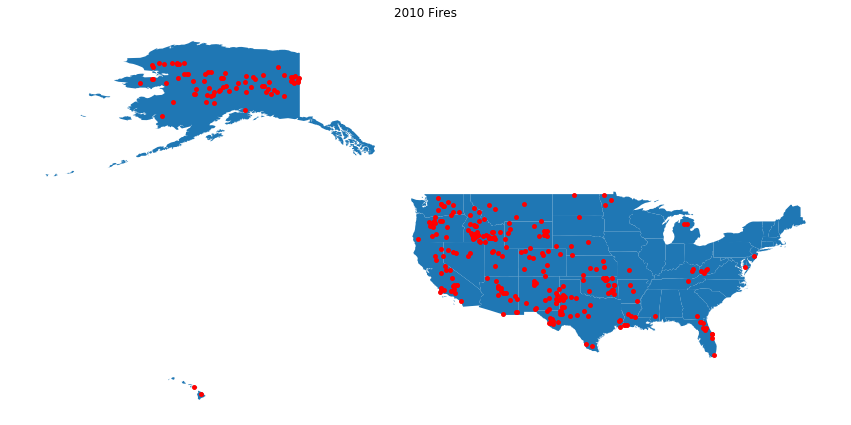

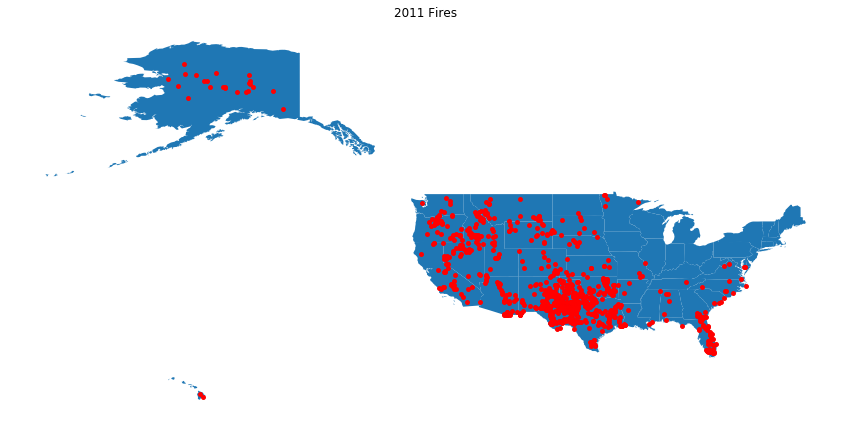

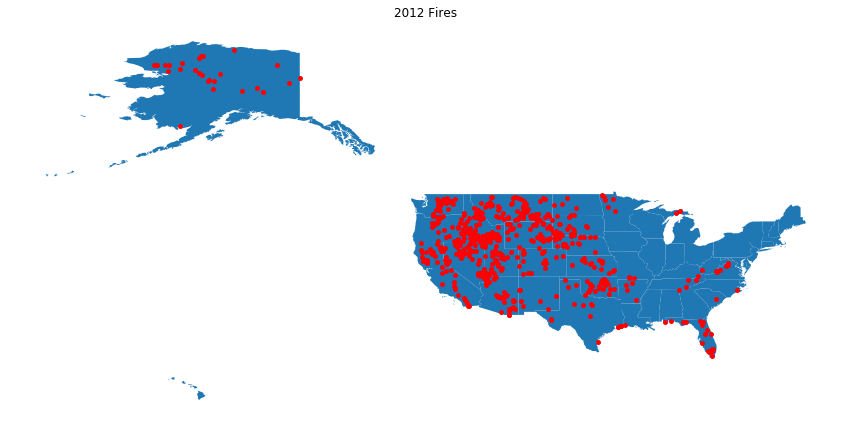

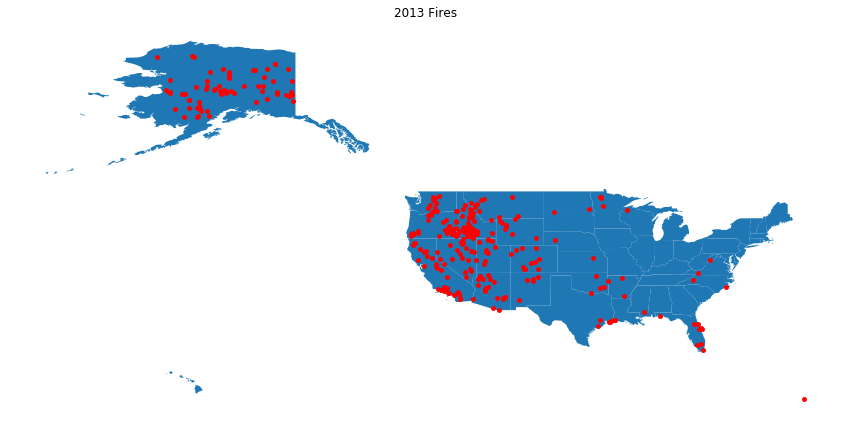

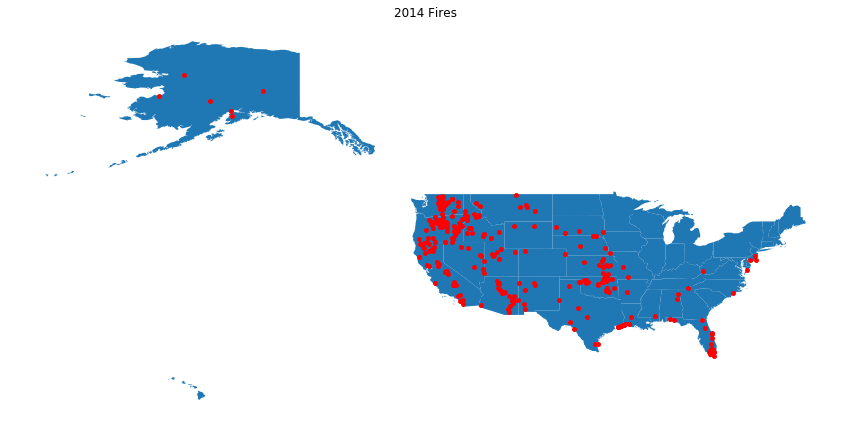

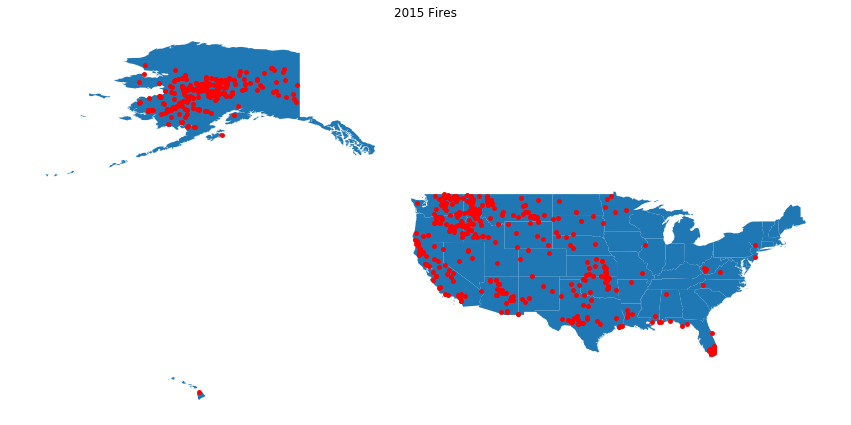

In [28]:
for y in years:
    y_df = large_df[large_df['FIRE_YEAR']==y]
    geometry = [Point(xy) for xy in zip(y_df['LONGITUDE'], y_df['LATITUDE'])]
    gdf = gpd.GeoDataFrame(y_df, geometry=geometry)
    fig = gdf.plot(ax=us_map.plot(figsize=(15,15)), marker='o', color='red', markersize=15);
    fig.axis('off')
    fig.set_title('{} Fires'.format(y))
    filepath = os.path.join('./', '{}_fires.jpg'.format(y))
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)

FOR BHARAT: calculate counties with the most wildfires